In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data = pd.read_csv('Electricity _Consumption_train.csv')
data.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [3]:
data.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

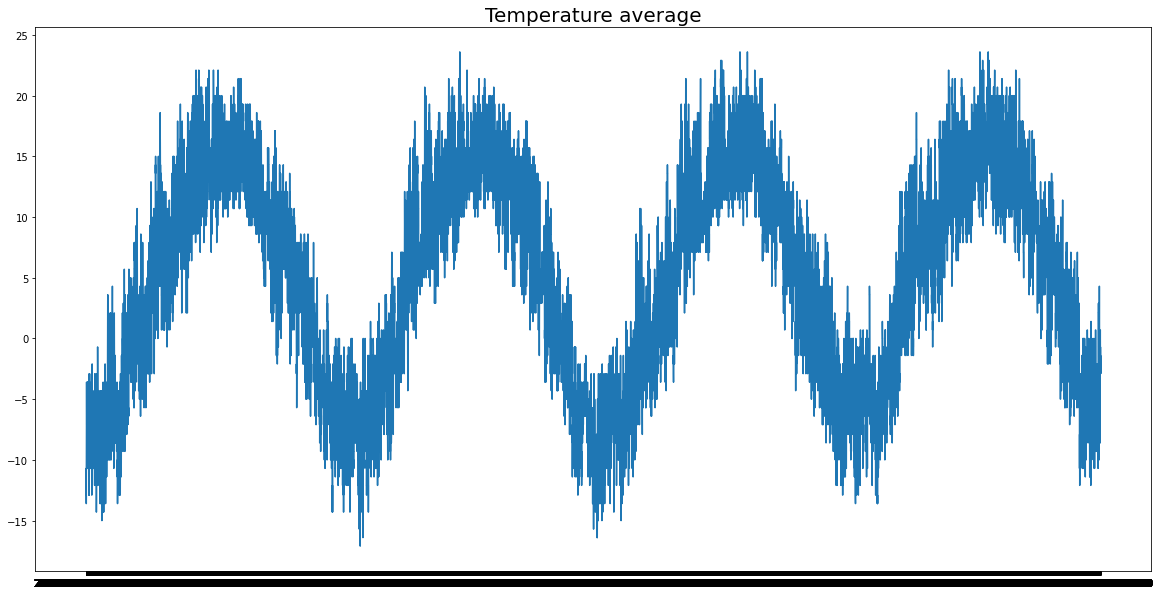

In [6]:
dates = data['datetime'].values
temp  = data['temperature'].values
plt.figure(figsize=(20,10))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dates, temp, test_size=0.2)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
seq_x_train = tokenizer.texts_to_sequences(X_train)
X_enc_train = tokenizer.sequences_to_matrix(seq_x_train,mode="tfidf")
seq_x_test  = tokenizer.texts_to_sequences(X_test)
X_enc_test  = tokenizer.sequences_to_matrix(seq_x_test,mode="tfidf")

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test , window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [21]:
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') is not None and logs.get('mae') < 4):  
      self.model.stop_training = True

callback = stopTraining()

In [22]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
num_epochs = 30
history = model.fit(train_set, epochs=num_epochs, batch_size=2, steps_per_epoch=30, 
                    validation_data=test_set,callbacks=[callback])

Epoch 1/30
30/30 [==============================] - 24s 441ms/step - loss: 8.2260 - mae: 8.7169 - val_loss: 7.9692 - val_mae: 8.4603
Epoch 2/30
30/30 [==============================] - 10s 340ms/step - loss: 7.8969 - mae: 8.3863 - val_loss: 7.8227 - val_mae: 8.3112
Epoch 3/30
30/30 [==============================] - 10s 333ms/step - loss: 7.6403 - mae: 8.1317 - val_loss: 7.5941 - val_mae: 8.0854
Epoch 4/30
30/30 [==============================] - 10s 334ms/step - loss: 7.4084 - mae: 7.9003 - val_loss: 7.2198 - val_mae: 7.7108
Epoch 5/30
30/30 [==============================] - 10s 336ms/step - loss: 7.1205 - mae: 7.6103 - val_loss: 7.0771 - val_mae: 7.5671
Epoch 6/30
30/30 [==============================] - 10s 336ms/step - loss: 6.9791 - mae: 7.4684 - val_loss: 7.0729 - val_mae: 7.5629
Epoch 7/30
30/30 [==============================] - 10s 334ms/step - loss: 6.8464 - mae: 7.3338 - val_loss: 7.0658 - val_mae: 7.5556
Epoch 8/30
30/30 [==============================] - 4s 125ms/step - l